In [9]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
import pickle
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
import csv

# Create output folders

these folders are used to output data from API query and created plots 

In [2]:
# check and make any folders that are needed by project (ouput and plots folder)

if not os.path.exists("output/"):
    os.mkdir("output/")


if not os.path.exists("plots/"):
    os.mkdir("plots/")


# Import and clean video report

import video report file that was downloaded from YouTube and is stored at filepath: 
'data/video_report_WMG_V_v1-3.csv'

Then clean data for use throughout code

In [21]:
# Pull in, clean, and, prep video file

# read in video report file
video_list = pd.read_csv('data/video_report_WMG_V_v1-3.csv', parse_dates=["time_published"], dtype={'video_privacy_status' : 'category', 'channel_id' : 'category'})

# make a copy df only with the columns I will need
video_list_clean = video_list[['video_id', 'channel_id', 'time_published', 'video_privacy_status']].copy()

# filter the new df so that it only has the rows that are public and have a publish date
privacy_filt = video_list_clean['video_privacy_status'] == 'Public'
publish_date_filt = video_list_clean['time_published'].notna()

video_list_clean = video_list_clean[privacy_filt & publish_date_filt]

# add new column that only shows month-year of publish date to use for month count later
video_list_clean['m_y_published'] = video_list_clean['time_published'].dt.strftime('%m-%y')


# Filter data to only show past 6 months of uploads
six_months_ago = dt(2020, 11, 1, 10, 4, 43, 100037)
time_filter = video_list_clean['time_published'] > six_months_ago
video_list_clean_recent = video_list_clean[time_filter].copy()


# set a new column that is the day date of upload to use for API
video_list_clean_recent['start_date'] = video_list_clean_recent['time_published'].dt.strftime('%Y-%m-%d')

# create a new column that has the 'end date' for api measurement
end_date_filt = video_list_clean_recent['time_published'] + timedelta(days=28)
video_list_clean_recent['end_date'] = end_date_filt.dt.strftime('%Y-%m-%d')

# group 'video_id' by 'start_date' and 'end_date' date so that I have lists of video_id's for each date for the API
video_list_for_api = video_list_clean_recent.groupby(['start_date', 'end_date'])['video_id'].apply(list)
video_list_for_api = video_list_for_api.reset_index()

# Import and clean central channel list

import central channel list from filepath: 'data/YT Central Channel List.xlsx'

then clean data for use within code

In [22]:
# central channel clean up

# Read in file
channel_list= pd.read_excel('data/YT Central Channel List.xlsx', sheet_name='In-Network Channels')

# clean up columns to only the ones I need
channel_list_clean = channel_list[['Channel ID', 'Public Name', 'Parent Label',]].copy()

# clean up column names
channel_list_clean.columns = channel_list_clean.columns.str.lower().str.replace(' ', '_')

# get rid of rows that don't have a parent_label
label_na_filter = channel_list_clean['parent_label'].notna()
channel_list_clean = channel_list_clean[label_na_filter]

# generate label list to see how many labesl are on sheet and then use this to randomly create groups to anonymize label
label_list = channel_list_clean['parent_label'].unique()
len(label_list)
np.random.seed(444)
channel_list_clean['group'] = np.random.randint(0, 64, len(channel_list_clean))

# drop parent_label column for my anonymized data for class
channel_list_clean.drop('parent_label', axis=1, inplace=True)

# clean up the channel list so it only has the columns needed
channel_list_summary = channel_list_clean[['channel_id', 'group']]

# Import and clean channel list

Import channel list from YouTube from filepath: 'data/channel_sub_list.csv'

Then clean up data for use in code

In [23]:
# YouTube Channel List for subscribers

# read in the channel subscriber list
channel_sub_list = pd.read_csv('data/channel_sub_list.csv')
channel_sub_list = channel_sub_list[['Channel ID', 'Subscribers']].copy()

# clean up header row
channel_sub_list.columns = channel_sub_list.columns.str.lower().str.replace(' ', '_')

# YouTube API Pull

Complete Oauth validation and create pickle file of credentials for future use

Query API to pull back views for all videos from the cleaned video file above

In [24]:
# API pull

credentials = None

# Token.pickle stores the user's credentials frm previously successful logins
if os.path.exists('token.pickle'):
    print('Loading Credentials From File...')
    with open('token.pickle', 'rb') as token:
        credentials = pickle.load(token)

if not credentials or not credentials.valid:
    if credentials and credentials.expired and credentials.refresh_token:
        print('Refreshing Access Token..')
        credentials.refresh(Request())
    else:
        print('Fetching New tokens...')
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secrets.json',
            scopes=['https://www.googleapis.com/auth/yt-analytics.readonly']
        )

        flow.run_local_server(
            port=8080, prompt='consent', authorization_prompt_message=''
        )
        credentials = flow.credentials

        # save the credentials for the next run
        with open('token.pickle', 'wb') as f:
            print('Saving Credentials for Future Use...')
            pickle.dump(credentials, f)
            
print('Processing Request...')

with build('youtubeAnalytics', 'v2', credentials=credentials) as service:
    for index, row in video_list_for_api.iterrows():
        start_date = (row['start_date'])
        end_date = (row['end_date'])
        video_ids = ','.join(row['video_id'])
        request = service.reports().query(
            startDate=start_date,
            endDate=end_date,
            filters=f"video=={video_ids}",
            dimensions='video',
            ids="contentOwner==CMS_ID",
            metrics="views",
        )
        response = request.execute()

        with open('/Users/jasonkillgore/Documents/Python/WMG/channel_video_upload_project/output/api_video_output.csv', 'a') as f:
            for ele in response['rows']:
                writer = csv.writer(f)
                writer.writerow(ele)

print('Request is completed')

Loading Credentials From File...
Refreshing Access Token..
Request is completed


# Merge and organize data

Merge and organize the data from above (video list, central channel list, YouTube channel list, and API view data) so that it is ready to plot

In [25]:
# Main Data analysis (Merge, clean, plot)

# pull back in data from API pull and merge into full data
api_data = pd.read_csv('output/api_video_output.csv', names=['video_id', '28_day_view'])
video_list_clean_recent = video_list_clean_recent.merge(api_data, on='video_id', how='inner')

# merge the channel groups with the recent video list
video_list_clean_recent = video_list_clean_recent.merge(channel_list_summary, on='channel_id', how='inner')

# merge the sub channel list with the recent video list
video_list_clean_recent = video_list_clean_recent.merge(channel_sub_list, on='channel_id', how='inner')

# number of months in file to calculate averge below
n_months = len(video_list_clean_recent['m_y_published'].unique())

# group video list by group and channel ID 
video_list_final_group = video_list_clean_recent.groupby(['group','channel_id']).agg({
                                                                                'm_y_published': 'unique', 
                                                                                'video_id': lambda x : list(x),
                                                                                '28_day_view' : 'sum',
                                                                                'subscribers' : 'unique',
})

# create a new column that contains the ratio of '28_day_view' / 'subscribers'
video_list_final_group['percent_views_to_sub'] = video_list_final_group['28_day_view'] / video_list_final_group['subscribers'].astype(int) * 100

# code to count the number of months videos were posted for each channel and then added back into DF
month_published_list = video_list_final_group['m_y_published'].apply(lambda x: x.tolist())
video_list_final_group['n_months_posted'] = month_published_list.apply(lambda x: len(x))

# Reset index so I can do a new grouping
group_summary = video_list_final_group.reset_index()

# create a group based on group number
group_summary = group_summary.groupby('group').agg({
                                                    'channel_id' : lambda x: x.tolist(),
                                                    '28_day_view' : 'sum',
                                                    'n_months_posted' : 'mean',
                                                    'percent_views_to_sub' : 'mean'

}).copy()

# filtering results by most viewed to least
group_summary.sort_values('28_day_view', ascending=False, inplace=True)

# Create Bar Plot Visualizations

Create bar plot visualizaiton of data showing:
1. the overall average posting frequency of all channels over the past 6 months, by label
2. overall average posting frequency by channel for each individual label

(These files are saved in the 'plots' folder)

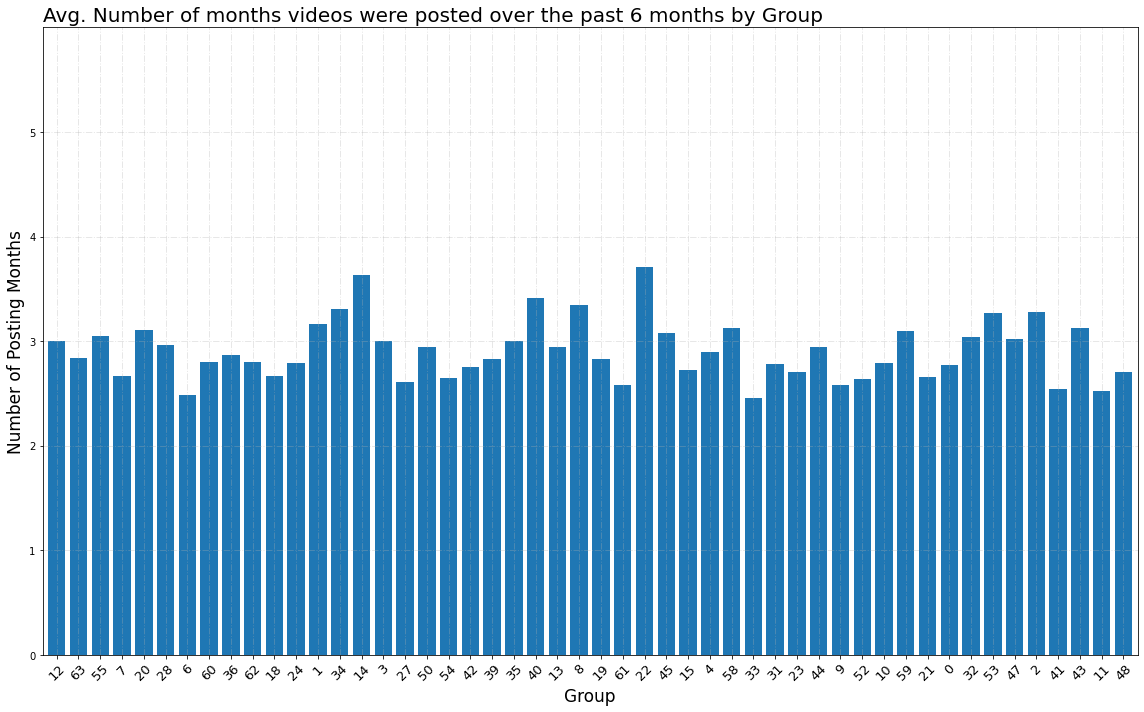

In [26]:
# Bar Plots

# Plot out based on number of Months Posted by top 50 Groups
group_summary.head(50).plot(
                            y='n_months_posted', 
                            kind='bar', 
                            legend=None, 
                            figsize=(16, 10),
                            align='center',
                            width=.8)
plt.grid(linestyle='dashdot', linewidth=1, alpha=.3)
# plt.minorticks_on()
plt.title(f'Avg. Number of months videos were posted over the past {n_months} months by Group', fontsize=20, loc='left')
plt.ylabel('Number of Posting Months', fontsize=17)
plt.xlabel('Group', fontsize=17)
plt.ylim(0, 6)
plt.yticks(np.arange(0, 6, 1))
plt.xticks(rotation=45, fontsize=13)
plt.tight_layout()

plt.savefig('plots/group-plot.png', facecolor='white')
;


# create a definition that will graph each channel within a label group
def channel_plot(df, label, sample_size):
    df.loc[label].sort_values('28_day_view', ascending=False).head(sample_size).plot(
                                                                                    y='n_months_posted', 
                                                                                    kind='bar', 
                                                                                    legend=None, 
                                                                                    figsize=(16, 10),
                                                                                    align='center',
                                                                                    width=.8)
    plt.grid(linestyle='dashdot', linewidth=1, alpha=.3)
    # plt.minorticks_on()
    plt.title(f'Avg. Number of Months over the past {n_months} months Posted by Top {label} Channels', fontsize=20, loc='left')
    plt.ylabel('Number of Months Posted', fontsize=17)
    plt.xlabel('Channel', fontsize=17)
    plt.ylim(0, 6)
    plt.yticks(np.arange(0, 6, 1))
    plt.xticks(rotation=90, fontsize=13)
    plt.tight_layout()
    
    
    if not os.path.exists("plots/"):
        os.mkdir("plots/")
        
    plt.savefig(f'plots/{label}.png', facecolor='white')
    
    plt.close()
    ;
    
# create a unique label list that you can then iterate through using above definition to create a graph of channel uploads by each group
label_list = channel_list_summary['group'].unique().tolist()
for i in label_list:
    channel_plot(video_list_final_group, i, 20)


# Create line plot visualizations

Create line plot visualizations to investigate the correlation between posting frequency and view volume

First plot show total views grouped by the number of months posted
(However the plot didn't show an expected trend line of increased views with increased posting frequency so created next plot where I tried to normalize the channel views by dividing them by channel subscribers to help control the larger channels driving larger view totals)

Second plot shows mean (views/subscribers) grouped by the number of months posted
(Still did not see expected results from this graph either and based on analyzing the data a bit further it seemed like there were some really large outliers in the data, so I reran the data with the final graph using the median value for (views/subscribers))

Third plot shows median (views/subscribers) grouped by the number of months posted
(this plot looks better but still isn't perfect and based on further analysis it looks like month time division may be too large and I need to dig deeper into all of this dividing posting frequency by week)

(These files are saved in the 'plots' folder)

In [28]:
# Line Plots

# reset index on df so I can sort differently and plot that
video_list_final = video_list_final_group.reset_index()

# Drop the channel with zero subscribers
video_list_final = video_list_final.drop(1389)
video_list_final[video_list_final['n_months_posted'] == 1].sort_values('subscribers').head(2)

# setup data so that I can plot the posting groups by the sum of views for each group
views_by_percent_posted = video_list_final.groupby('n_months_posted')['28_day_view'].sum()
views_by_percent_posted = views_by_percent_posted.reset_index()

# Plot this
views_by_percent_posted.plot(
                            kind='line',
                            y='28_day_view',
                            x='n_months_posted',
                            legend=None, 
                            figsize=(14, 8),
)
plt.grid(linestyle='dashdot', linewidth=1, alpha=.3)
plt.title('Total Views by number of months posted', fontsize=20, loc='left')
plt.ylabel('Views', fontsize=17)
plt.xlabel('Months Posted', fontsize=17)
plt.ticklabel_format(style = 'plain')
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
if not os.path.exists("plots/"):
        os.mkdir("plots/")
        
plt.savefig('plots/Total_Views_by_number_of_months_posted.png', facecolor='white')
plt.close()


# setup data so that I can plot the posting groups by the average of percent_views_to_sub for each group
views_by_percent_posted = video_list_final.groupby('n_months_posted')['percent_views_to_sub'].mean()
views_by_percent_posted = views_by_percent_posted.reset_index()

# Plot this
views_by_percent_posted.plot(
                            kind='line',
                            y='percent_views_to_sub',
                            x='n_months_posted',
                            legend=None, 
                            figsize=(14, 8),
)
plt.grid(linestyle='dashdot', linewidth=1, alpha=.3)
plt.title('Average views/subscriber based on months posted', fontsize=20, loc='left')
plt.ylabel('Views', fontsize=17)
plt.xlabel('Months Posted', fontsize=17)
plt.ticklabel_format(style = 'plain')
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
if not os.path.exists("plots/"):
        os.mkdir("plots/")
        
plt.savefig('plots/Average_views_per_subscriber_based_on_months_posted.png', facecolor='white')
plt.close()


# setup data so that I can plot the posting groups by the median of percent_views_to_sub for each group
views_by_percent_posted = video_list_final.groupby('n_months_posted')['percent_views_to_sub'].median()
views_by_percent_posted = views_by_percent_posted.reset_index()

# Plot this
views_by_percent_posted.plot(
                            kind='line',
                            y='percent_views_to_sub',
                            x='n_months_posted',
                            legend=None, 
                            figsize=(14, 8),
)
plt.grid(linestyle='dashdot', linewidth=1, alpha=.3)
plt.title('Median views/subscriber based on months posted', fontsize=20, loc='left')
plt.ylabel('Views', fontsize=17)
plt.xlabel('Months Posted', fontsize=17)
plt.ticklabel_format(style = 'plain')
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
if not os.path.exists("plots/"):
        os.mkdir("plots/")
        
plt.savefig('plots/Median_views_per_subscriber_based_on_months_posted.png', facecolor='white')
plt.close()
